In [19]:
using Pkg
Pkg.add("StaticArrays")

   Resolving package versions...
   Installed StaticArrays ─ v1.2.13
    Updating `~/.julia/dev/AD_GS/Project.toml`
  [90137ffa] + StaticArrays v1.2.13
    Updating `~/.julia/dev/AD_GS/Manifest.toml`
  [90137ffa] ↑ StaticArrays v1.2.12 ⇒ v1.2.13
Precompiling project...
  ✓ StaticArrays
  ✓ Contour
  ✓ DiffResults
  ✓ StructArrays
  ✓ FiniteDiff
  ✓ Interpolations
  ? GeometryBasics
  ✓ IntervalArithmetic
  ? Plots
  ✓ ForwardDiff
  ? NLSolversBase
  ? Equilibrium
  ? JuMP
  ? LazySets
  ? AD_GS
8 dependencies successfully precompiled in 14 seconds (159 already precompiled)
7 dependencies failed but may be precompilable after restarting julia


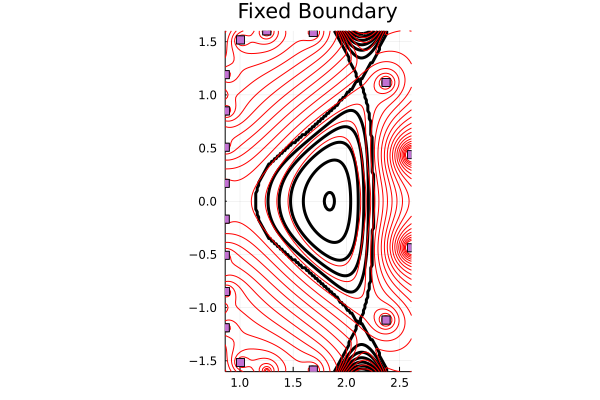

  0.038715 seconds (15.13 k allocations: 5.149 MiB)


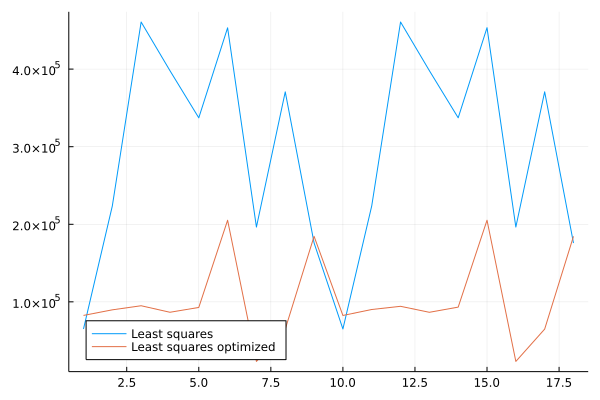

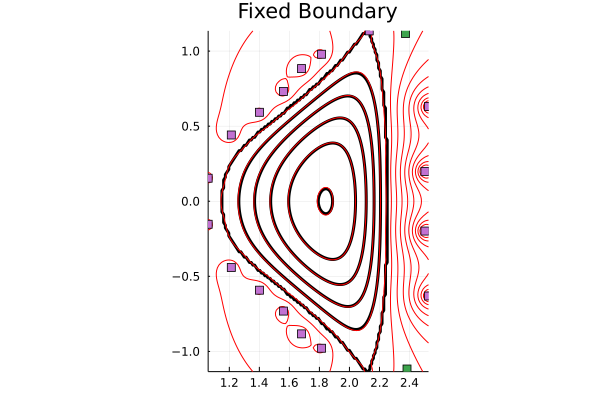

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     5.268238e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   17  (vs limit 30)
    Iterations:    10000
    f(x) calls:    13265
  0.038815 seconds (15.13 k allocations: 5.149 MiB)
λ_regularize = 5.246729482050645e-14


In [3]:
using Revise
using AD_GS
import Equilibrium
using Plots
using Optim
using LinearAlgebra

# Change between coils_D3D and coils_D3D_points to run with finite or singular coils
coils = coils_D3D_points

symmetric=true
λ_regularize = 1E-13

δ = 0.7
ϵ = 0.32
κ = 1.9
B0 = 2.0
R0 = 1.8
qstar = 1.57
alpha = -0.155
S = Equilibrium.solovev(B0, R0, ϵ, δ, κ, alpha, qstar, B0_dir=1,Ip_dir=1,diverted=true,symmetric=symmetric)

δ = -0.7
ϵ = 0.32
κ = 1.9
B0 = 2.0
R0 = 1.7
qstar = 1.57
alpha = -0.155
S = Equilibrium.solovev(B0, R0, ϵ, δ, κ, alpha, qstar,B0_dir=1,Ip_dir=1,diverted=true,symmetric=symmetric)

function pack(coils, λ_regularize)
    coilz = vcat([c[1] for c in coils if ((! symmetric) || c[2]>0)],[c[2] for c in coils if ((! symmetric) || c[2]>0)])
    packed = vcat(coilz, λ_regularize)
    return packed
end
function unpack(packed)
    coilz = packed[1:end-1]
    λ_regularize = abs(packed[end])
    coils =  [(coilz[k],coilz[k+Int(length(coilz)/2)]) for (k,c) in enumerate(coilz[1:Int(end/2)])]
    if symmetric
        coils = vcat(coils,[(c[1],-c[2]) for c in coils])
    end
    return coils, λ_regularize
end

packed = pack(coils, λ_regularize)
(coils, λ_regularize) = unpack(packed)

xlim=(minimum([c[1] for c in coils]),maximum([c[1] for c in coils]))
ylim=(minimum([c[2] for c in coils]),maximum([c[2] for c in coils]))

@time currents = fixed_eq_currents(S,coils,λ_regularize=λ_regularize,λ_minimize=0.0, λ_zerosum=0.0, λ_d3d_innersum=0.0)
check_fixed_eq_currents(S,coils,currents,resolution=129)
plot!([c[1] for c in coils],[c[2] for c in coils],markershape=:rect,lw=0,label="")
display(plot!([c[1] for c in coils],[c[2] for c in coils],markershape=:rect,lw=0,label=""))
plot(abs.(currents),label="Least squares", legend=:bottomleft)

function optimize_coils(S, coils, λ_regularize, symmetric=true)
    
    fixed_eq = ψp_on_fixed_eq_boundary(S)
    packed = pack(coils, λ_regularize)
        
    function placement_cost(packed)
        (coils, λ_regularize) = unpack(packed)
        currents, cost = currents_to_match_ψp(fixed_eq...,coils, λ_regularize=λ_regularize, λ_minimize=0.0, λ_zerosum=0.0, λ_d3d_innersum=0.0, return_cost=true)
        cost += norm(currents)*1E-3
        return cost
    end
        
    res = Optim.optimize(placement_cost, packed, Optim.NelderMead(), Optim.Options(time_limit=30, iterations=10000))#; autodiff=:forward)
    print(res)

    packed = Optim.minimizer(res)
    
    (coils, λ_regularize) = unpack(packed)
    return coils, λ_regularize
end

(coils,λ_regularize) = optimize_coils(S, coils, λ_regularize, symmetric)

@time currents = fixed_eq_currents(S, coils, λ_regularize=λ_regularize, λ_minimize=0.0, λ_zerosum=0.0, λ_d3d_innersum=0.0, verbose=true)
display(plot!(abs.(currents),label="Least squares optimized", legend=:bottomleft))
check_fixed_eq_currents(S,coils,currents,resolution=129)
plot!([c[1] for c in coils_D3D_points],[c[2] for c in coils_D3D_points],markershape=:rect,lw=0,label="")
display(plot!([c[1] for c in coils],[c[2] for c in coils],markershape=:rect,lw=0,label=""))

@show(λ_regularize);